# JijZept Solverハンズオン

## 1. パッケージのインストール
最初に、このノートブック実行に必要なパッケージをインストールします。

In [ ]:
# 必要なパッケージをインストール
!pip install jijzept_solver jijmodeling ommx_pyscipopt_adapter matplotlib

## 2. JijZept Solver 環境設定

In [ ]:
import os

os.environ["JIJZEPT_SOLVER_SERVER_HOST"] = "APIサーバーのホスト名"
os.environ["JIJZEPT_SOLVER_ACCESS_TOKEN"] = "アクセストークン"

## 3. ジョブショップスケジューリング問題の解説

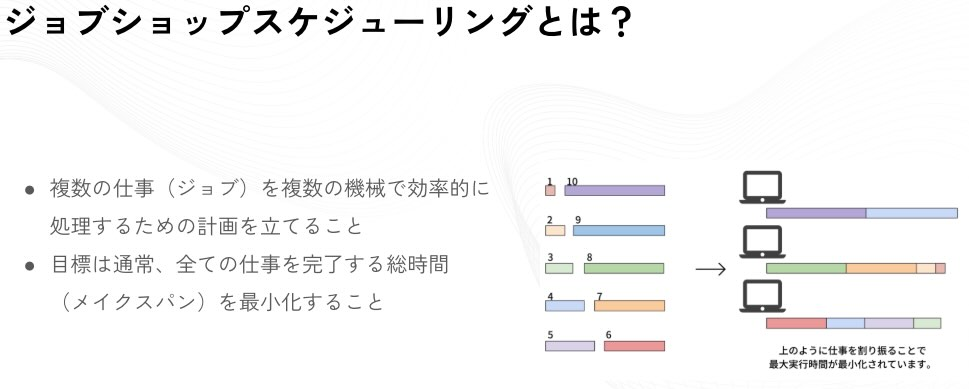

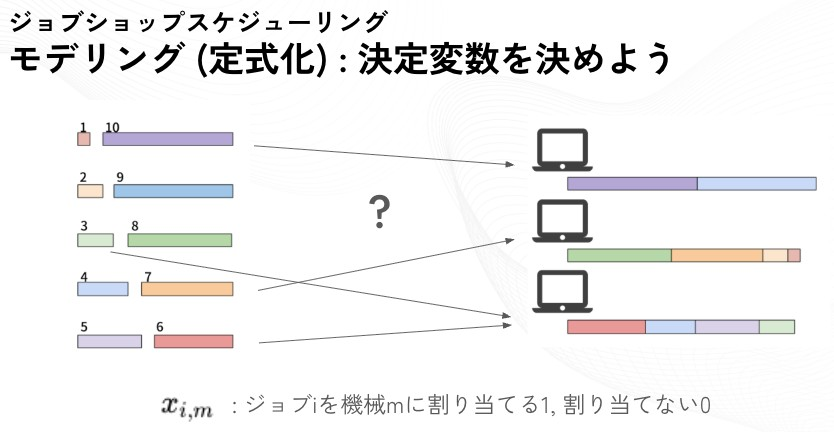

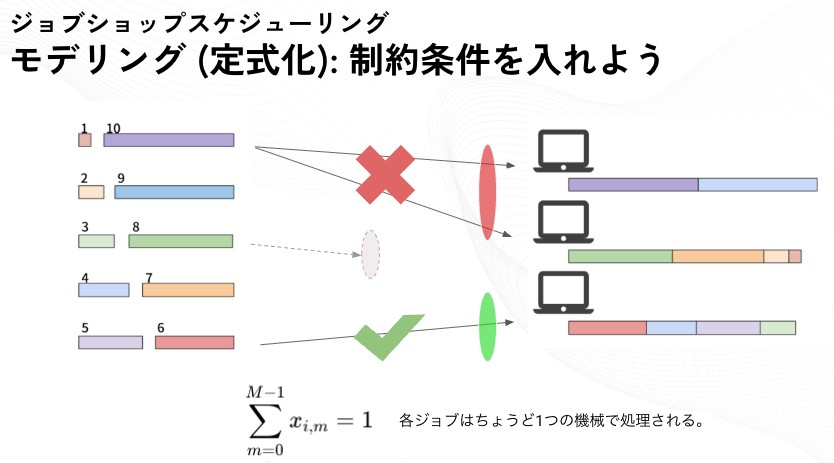

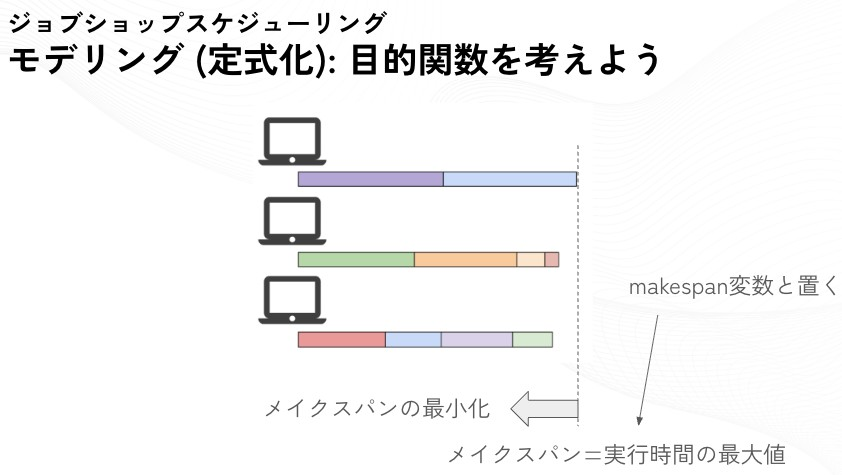

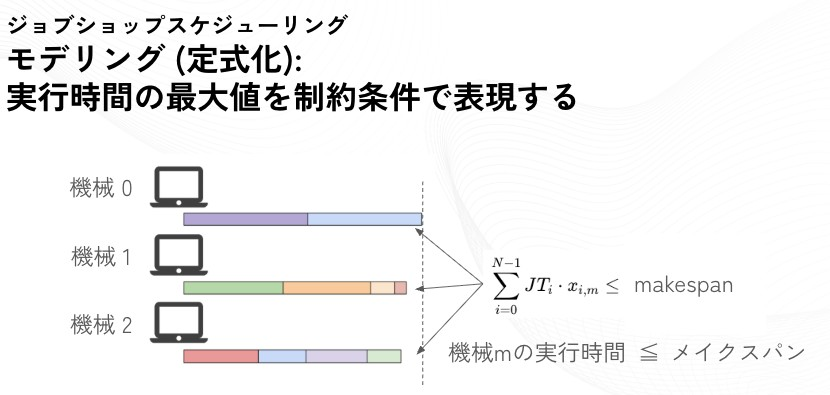

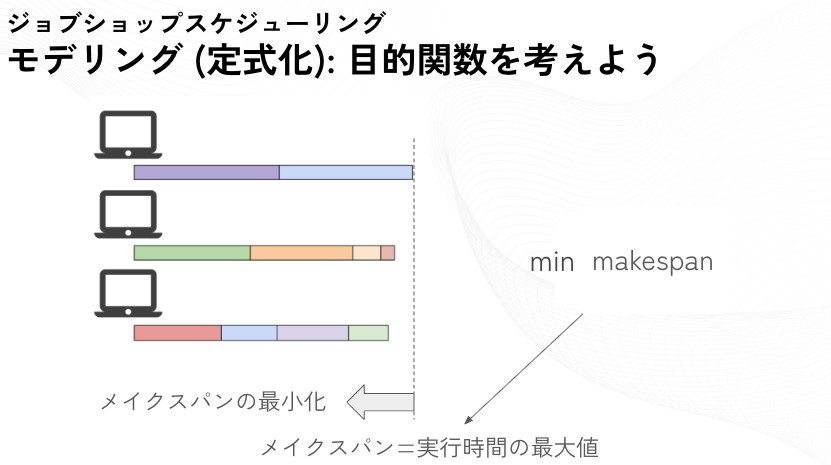

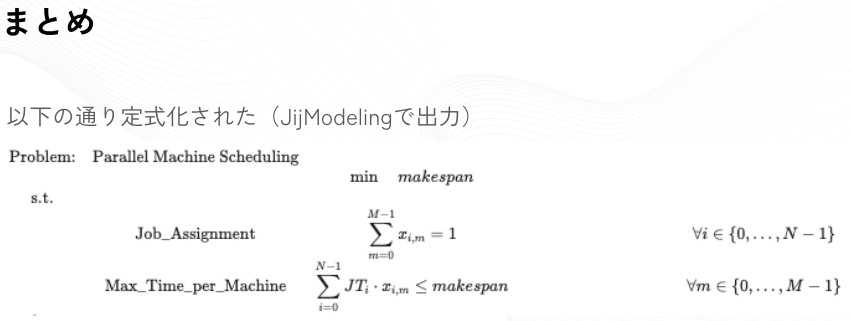

## 4. 数理モデルの定義（JijModeling）

JijModelingを使用して、このジョブショップスケジューリング問題をモデリングします。

In [ ]:
# 必要なライブラリをインポート
import jijmodeling as jm

# --- 1. プレースホルダ（入力データ） ---
# JT[i]: ジョブiの処理時間
JT = jm.Placeholder("JT", ndim=1, description="Processing time for job i")
# N: ジョブ数（JTの長さから導出）
N = JT.len_at(0, latex="N", description="Number of jobs")
# M: 機械数
M = jm.Placeholder("M", description="Number of machines")

# --- 2. 要素（インデックス） ---
# i: ジョブのインデックス（0からN-1）
i = jm.Element("i", belong_to=(0, N), description="Index for jobs")
# m: 機械のインデックス（0からM-1）
m = jm.Element("m", belong_to=(0, M), description="Index for machines")

# --- 3. 変数（決定変数と補助変数） ---
# x[i, m]: バイナリ変数、ジョブiが機械mに割り当てられる場合は1、そうでない場合は0
x = jm.BinaryVar(
    "x",
    shape=(N, M),
    description="x[i, m]: 1 if job i is assigned to machine m, else 0",
)
# makespan: すべての機械にわたる最大完了時間を表す連続変数
makespan = jm.ContinuousVar(
    "makespan",
    lower_bound=0,
    upper_bound=jm.sum(i, JT[i]),
    description="Makespan: The completion time of the last job across all machines",
)

# --- 4. 問題の定義 ---
problem = jm.Problem("Parallel Machine Scheduling")

# --- 5. 制約 ---
# 制約1：各ジョブ 'i' は正確に1つの機械 'm' に割り当てられなければならない
problem += jm.Constraint(
    "Job_Assignment",
    jm.sum(m, x[i, m]) == 1,
    forall=i,
)
# 制約2：任意の機械 'm' の総処理時間はメイクスパン以下でなければならない
problem += jm.Constraint(
    "Max_Time_per_Machine",
    jm.sum(i, JT[i] * x[i, m]) <= makespan,
    forall=m,
)

# --- 6. 目的関数 ---
# メイクスパンを最小化
problem += makespan

problem

## 5. 可視化関数の定義

結果を可視化（ガントチャート等）するための関数を定義しておきます。

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def analyze_schedule_results(solution, instance_data):
    x_result: dict[tuple[int, ...], float] = solution.extract_decision_variables("x")
    
    makespan_value = solution.objective
    print(f"\n--- Solver Results ---")
    print(f"Makespan: {makespan_value:.2f}")
    assignment = {}  # {機械インデックス: [ジョブインデックス, ...]}
    assigned_jobs_flat = (
        []
    )  # DataFrameに格納するデータ: [{'Job': i, 'Machine': m, 'Time': t}]
    x_result = {}

    x_result = solution.extract_decision_variables("x")

    # 抽出したx_result辞書を処理
    num_machines_instance = instance_data["M"]
    for indices, val in x_result.items():
        if len(indices) == 2 and val > 0.5:  # バイナリ '1' をチェック
            i, m = indices  # インデックスをアンパック
            if m not in assignment:
                assignment[m] = []
            assignment[m].append(i)
            # JTにアクセスする前にジョブインデックスiが有効であることを確認
            if 0 <= i < len(instance_data["JT"]):
                assigned_jobs_flat.append(
                    {"Job": i, "Machine": m, "Time": instance_data["JT"][i]}
                )
            else:
                print(
                    f"Warning: Invalid job index {i} found in solution variable 'x' for machine {m}."
                )

    print("\nJob Assignments per Machine:")
    if assignment:
        for m_idx in range(num_machines_instance):
            assigned_jobs = sorted(assignment.get(m_idx, []))
            print(f"  Machine {m_idx}: Jobs {assigned_jobs}")
    else:
        print("  No assignments could be extracted from 'x' variables.")

    if assigned_jobs_flat:
        assignment_df = pd.DataFrame(assigned_jobs_flat)
        print("\nAssignment Details (DataFrame):")
        print(
            assignment_df.sort_values(by=["Machine", "Job"]).reset_index(
                drop=True
            )
        )
    else:
        print("\nAssignment Details (DataFrame): Empty")
        assignment_df = pd.DataFrame()
    
    print("\n--- Result Analysis ---")
    print("Total Processing Time (Load) per Machine:")
    machine_loads = {m: 0 for m in range(num_machines_instance)}
    machine_load_list = []
    job_times = instance_data["JT"]

    for m_idx in range(num_machines_instance):
        load = 0
        assigned_job_indices = assignment.get(m_idx, [])
        for job_idx in assigned_job_indices:
            if 0 <= job_idx < len(job_times):
                load += job_times[job_idx]
            else:
                print(
                    f"Warning: Invalid job index {job_idx} found for machine {m_idx} during load calculation."
                )
        machine_loads[m_idx] = load
        machine_load_list.append(load)
        print(f"  Machine {m_idx}: {load:.2f}")

    calculated_max_load = max(machine_load_list) if machine_load_list else 0
    print(f"\nCalculated Maximum Machine Load: {calculated_max_load:.2f}")
    print(f"(Solver's Makespan: {makespan_value:.2f})")
    if abs(calculated_max_load - makespan_value) < 1e-6:
        print("-> Verification successful: Makespan matches the maximum machine load.")
    else:
        print(
            "-> WARNING: Makespan does NOT match the calculated maximum load. Check model/solver."
        )
    
    return {
        'makespan_value': makespan_value,
        'assignment': assignment,
        'machine_loads': machine_loads,
        'machine_load_list': machine_load_list,
        'assignment_df': assignment_df,
        'job_times': job_times,
        'num_machines': num_machines_instance
    }


def plot_machine_load_chart(analysis_results):
    makespan_value = analysis_results['makespan_value']
    machine_load_list = analysis_results['machine_load_list']
    num_machines_instance = analysis_results['num_machines']
    
    # --- 可視化1: 棒グラフ ---
    print("\n--- Visualization ---")
    plt.figure(figsize=(8, 5))
    machines = [f"Machine {m}" for m in range(num_machines_instance)]
    bars = plt.bar(machines, machine_load_list, color="skyblue", edgecolor="black")
    plt.axhline(
        makespan_value,
        color="red",
        linestyle="--",
        label=f"Makespan ({makespan_value:.2f})",
    )

    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            yval,
            f"{yval:.2f}",
            va="bottom",
            ha="center",
        )

    plt.xlabel("Machine")
    plt.ylabel("Total Processing Time (Load)")
    plt.title("Machine Load Distribution")
    plt.legend()
    plt.grid(axis="y", linestyle=":", alpha=0.7)
    plt.ylim(0, makespan_value * 1.15)
    plt.tight_layout()
    plt.show()


def plot_gantt_chart(analysis_results):
    assignment = analysis_results['assignment']
    makespan_value = analysis_results['makespan_value']
    job_times = analysis_results['job_times']
    num_machines_instance = analysis_results['num_machines']
    num_jobs_instance = len(job_times)
    
    # --- 可視化2: ガントチャート ---
    # このチャートは各機械に割り当てられたジョブを順番に表示します。
    # 横軸は時間を表します。

    fig, ax = plt.subplots(figsize=(12, max(4, num_machines_instance * 0.8)))
    machine_end_times = np.zeros(num_machines_instance)

    base_cmap = plt.colormaps.get_cmap("tab20")
    job_colors = [base_cmap((i % 20) / 20) for i in range(num_jobs_instance)]  # ジョブごとに異なる色

    print("\nGenerating Gantt-style assignment chart...")

    # 機械とそれに割り当てられたジョブを反復処理
    for m_idx in range(num_machines_instance):
        assigned_job_indices = sorted(assignment.get(m_idx, []))

        for job_idx in assigned_job_indices:
            if 0 <= job_idx < len(job_times):
                job_time = job_times[job_idx]
                start_plot_time = machine_end_times[m_idx]

                # ジョブのバーをプロット
                ax.barh(
                    m_idx,
                    job_time,
                    left=start_plot_time,
                    height=0.6,
                    align="center",
                    color=job_colors[job_idx % len(job_colors)],
                    edgecolor="black",
                    alpha=0.8,
                )

                text_x = start_plot_time + job_time / 2.0
                text_y = m_idx
                ax.text(
                    text_x,
                    text_y,
                    f"J{job_idx}",
                    va="center",
                    ha="center",
                    color="white",
                    fontweight="bold",
                    fontsize=9,
                )

                machine_end_times[m_idx] += job_time
            else:
                print(
                    f"Skipping plotting for invalid job index {job_idx} on machine {m_idx}"
                )

    # --- プロットの外観を設定 ---
    ax.set_xlabel("Execution Time")
    ax.set_ylabel("Machine Number")
    # y軸の目盛りを機械インデックスに合わせる
    ax.set_yticks(range(num_machines_instance))
    ax.set_yticklabels(
        [f"{m}" for m in range(num_machines_instance)]
    )
    ax.set_title("Gantt-Style Chart: Job Assignments per Machine")

    ax.invert_yaxis()  # 機械0を上部に表示
    plt.grid(axis="x", linestyle=":", alpha=0.6)
    plt.xlim(0, makespan_value * 1.05)
    plt.tight_layout()
    plt.show()

## 6. ステップ1：小さいインスタンスを解く

まず、ジョブショップスケジューリング問題の小さなインスタンスを解いてみます。

### 6-1. インスタンスデータの準備

In [ ]:
# 例: それぞれの処理時間を持つ10個のジョブ
job_times_data = [5, 8, 3, 6, 9, 4, 7, 5, 2, 8]
# 例: 3台の機械が利用可能
num_machines_data = 3

# JijModelingプレースホルダに必要な辞書形式でデータを準備
instance_data = {
    "JT": job_times_data,
    "M": num_machines_data,
}

print("Instance Data:")
print(f"  Job Processing Times (JT): {instance_data['JT']}")
print(f"  Number of Machines (M): {instance_data['M']}")
print(f"  Number of Jobs (N derived): {len(instance_data['JT'])}")

### 6-2. JijModelingによるインスタンスの作成

In [ ]:
# 1. 特定のインスタンスデータで問題を評価するためのインタープリタを作成
interpreter = jm.Interpreter(instance_data)
# 2. 問題を評価してソルバー用の具体的なインスタンスを作成
instance = interpreter.eval_problem(problem)

### 6-3. JijZept Solverを使用したインスタンスの求解

上で作成したインスタンスを、JijZept Solverを使って求解します。

In [ ]:
# JijZept Solverをインポート
import jijzept_solver

# JijZept Solverを使用してインスタンスを求解
solution = jijzept_solver.solve(instance, time_limit_sec=3.0)

### 6-4. 結果の可視化

JijZept Solverから返された `solution` オブジェクトから、結果を見てみます。

In [ ]:
# 結果を解析
results_small = analyze_schedule_results(solution, instance_data)

グラフによる可視化を行います。各機械の総処理時間を計算し、算出されたメイクスパンと一致することが確認できます。

In [ ]:
# 各機械の処理時間の棒グラフを表示
plot_machine_load_chart(results_small)

In [ ]:
# 各機械の処理時間のガントチャートを表示
plot_gantt_chart(results_small)

## 7. ステップ2：大きいインスタンスを解く

次に、より大きなインスタンスを解いてみます。

### 7-1. インスタンスデータの準備

In [ ]:
# 例: 500個のジョブ（10個のジョブ*50）それぞれの処理時間
job_times_data_large = [5, 8, 3, 6, 9, 4, 7, 5, 2, 8] * 50

# 例: 100台の機械が利用可能
num_machines_data_large = 100

# JijModelingプレースホルダに必要な辞書形式でデータを準備
instance_data_large = {
    "JT": job_times_data_large,
    "M": num_machines_data_large,
}

print("Large Instance Data:")
print(f"  Job Processing Times (JT): {instance_data_large['JT'][:10]}... (showing first 10)")
print(f"  Number of Machines (M): {instance_data_large['M']}")
print(f"  Number of Jobs (N derived): {len(instance_data_large['JT'])}")

### 7-2. JijModelingによるインスタンスの作成

In [ ]:
# 1. 特定のインスタンスデータで問題を評価するためのインタープリタを作成
interpreter_large = jm.Interpreter(instance_data_large)
# 2. 問題を評価してソルバー用の具体的なインスタンスを作成
instance_large = interpreter_large.eval_problem(problem)

### 7-3. SCIPを使用したインスタンスの求解（OMMXPySCIPOptAdapter）

今回は、2つのソルバー（JijZeptSolver, SCIP）での求解を試してみます。
まずは、ommx-pyscipopt-adapterによって提供されるSCIPで解いてみます。

In [ ]:
# 必要なアダプターをインポート
from ommx_pyscipopt_adapter import OMMXPySCIPOptAdapter

# OMMX SCIPアダプターを使用してインスタンスを求解
adapter = OMMXPySCIPOptAdapter(instance_large)
model = adapter.solver_input
model.setParam("limits/time", 3.0)
model.optimize()
solution_large_scip = adapter.decode(model)

In [ ]:
# 結果を解析
results_large_scip = analyze_schedule_results(solution_large_scip, instance_data_large)

In [ ]:
# 各機械の処理時間の棒グラフを表示
plot_machine_load_chart(results_large_scip)

In [ ]:
# 各機械の処理時間のガントチャートを表示
plot_gantt_chart(results_large_scip)

### 7-4. JijZept Solverを使用したインスタンスの求解

次に、JijZept Solverで解きます。

In [ ]:
# JijZept Solverを使用してインスタンスを求解
solution_large_jijzept_solver = jijzept_solver.solve(instance_large, time_limit_sec=3.0)

In [ ]:
# 結果を解析
results_large_jijzept_solver = analyze_schedule_results(solution_large_jijzept_solver, instance_data_large)

In [ ]:
# 各機械の処理時間の棒グラフを表示
plot_machine_load_chart(results_large_jijzept_solver)

In [ ]:
# 各機械の処理時間のガントチャートを表示
plot_gantt_chart(results_large_jijzept_solver)

## 8. まとめ

このノートブックでは、**ジョブショップスケジューリング問題**をJijModelingで定式化し、JijZept Solverを使って最適化を行いました。

実施した内容：
* 複数のジョブを並列機械に効率的に割り当てる問題を設定し、全体の処理完了時間（メイクスパン）を最小化する目的関数を定義しました
* JijModelingを活用して、ジョブの機械への割り当てを表すバイナリ変数 `x[i, m]` と、メイクスパンを表す連続変数を用いた数理モデルを構築しました
* 各ジョブが必ず1つの機械に割り当てられること、各機械の処理時間がメイクスパン以下になることを制約として設定しました
* 小規模と大規模の2つのインスタンスで検証を実施しました
* 求解結果をガントチャート等で可視化し、最適化の効果を確認しました

今回は比較的シンプルなモデルでJijZept Solverの使い方を体験していただきました。

より複雑な制約条件や大規模なインスタンスを持つ実務的な最適化問題においても、JijZept Solverを活用することができます。